In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot
from math import sqrt
from pytz import timezone

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.utils.np_utils import to_categorical
from keras import optimizers

Using TensorFlow backend.


In [3]:
# Fix the random seed to reproducibility
np.random.seed(7)

In [4]:
def get_X_data():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu")
    return X

In [5]:
def get_y_data():
    y = pd.read_csv("93013_20170705_ALLSig.csv", index_col=[0], names=["date_time", "sig"], parse_dates=["date_time"])
    y = y.tz_localize(timezone("Asia/Shanghai"))
    return y

In [6]:
X = get_X_data()
y = get_y_data()

In [7]:
X = X["2012":]
y = y["2012":]

In [8]:
# Use difference in X as a predicator
X = X.diff()
X = X.fillna(0)

In [9]:
timelag=100

In [10]:
def timeseries_to_supervised(raw_time_series, lag):
    p = {}
    for i in range(1, lag+1):
        p["{}".format(i)] = raw_time_series.shift(i).fillna(0)
    p["0"] = raw_time_series
    
    supervised_data = pd.Panel(p)
    return supervised_data

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

def create_supervised_X(raw_time_series, lag):
    supervised_X = timeseries_to_supervised(X, 10)
    swaped_supervised_X = supervised_X.swapaxes(0, 1)
    return swaped_supervised_X

In [13]:
supervised_X = create_supervised_X(X, lag=timelag)
supervised_X = supervised_X.fillna(0)
supervised_X_values = supervised_X.values

In [14]:
supervised_X.items[350218:][0]

Timestamp('2016-03-01 13:28:00+0800', tz='Asia/Shanghai')

In [15]:
X_train, X_test, y_train, y_test = non_shuffling_train_test_split(X, y, test_size=0.3)

In [16]:
X_train = X_train[218:]
y_train = y_train[218:]

In [17]:
len(X_train)

350000

In [18]:
len(supervised_X)

500310

In [19]:
X_test = X_test[92:]
y_test = y_test[92:]

In [20]:
len(X_test)

150000

In [21]:
assert(not X_test.isnull().values.any())
assert(not X_train.isnull().values.any())
assert(not y_test.isnull().values.any())
assert(not y_train.isnull().values.any())

In [22]:
def scale(X_train, X_test):
    # scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
    scaler = Normalizer()
    # scaler = RobustScaler()
    scaler = scaler.fit(X_train, y_train)
    train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    return scaler, train_scaled, test_scaled

In [23]:
def inverse_scale(scaler, X_train_scaled, X_test_scaled):
    X_train = scaler.inverse_transform(X_train_scaled)
    X_test = scaler.inverse_transform(X_test_scaled)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train_scaled.index, columns=X_train_scaled.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test_scaled.index, columns=X_test_scaled.columns)
    return scaler, X_train, X_test

In [24]:
scaler, X_train_scaled, X_test_scaled = scale(X_train, X_test)

In [25]:
time_series_step = timelag
features = X_train.shape[1]

In [26]:
X_train_supervised_scaled = timeseries_to_supervised(X_train_scaled, time_series_step)
X_train_supervised_scaled = X_train_supervised_scaled.swapaxes(0, 1)

In [27]:
X_test_supervised_scaled = timeseries_to_supervised(X_test_scaled, time_series_step)
X_test_supervised_scaled = X_test_supervised_scaled.swapaxes(0, 1)

In [28]:
batch_size = 1000

In [29]:
X_train_supervised_scaled.values.shape

(350000, 101, 6)

In [30]:
scaler = MinMaxScaler()

In [31]:
scaler.fit(y_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [32]:
y_train_scaled = scaler.transform(y_train)

In [33]:
y_train_category = to_categorical(y_train, num_classes=3)

In [34]:
np.isnan(X_train_supervised_scaled.values).any()

False

In [47]:
model = Sequential()
model.add(
    LSTM(128, batch_input_shape=(batch_size, time_series_step+1, features), stateful=True, 
         return_sequences=True, 
         activation="relu"
        ))

model.add(
    LSTM(128, batch_input_shape=(batch_size, time_series_step+1, features), stateful=True, 
         return_sequences=True, 
         activation="relu"
        ))
    
model.add(LSTM(32, activation="relu", stateful=True))
# model.add(LSTM(8, activation="relu", stateful=True))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(3, activation="sigmoid"))
# model.add(Activation('softmax'))

In [48]:
sgd = optimizers.SGD(lr=1e-8, decay=1e-9, momentum=0.9, nesterov=True, clipnorm=1.)

In [49]:
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

In [50]:
num_epochs = 1
for i in range(num_epochs):
    model.fit(
        X_train_supervised_scaled.values, 
        y_train_category,
        epochs=4,
        batch_size=batch_size,
        verbose=1,
        shuffle=False,
        validation_split=0.2)
    model.reset_states()

Train on 280000 samples, validate on 70000 samples
Epoch 1/4
280000/280000 [==============================] - 1823s - loss: 1.0989 - acc: 0.2863 - val_loss: 1.0989 - val_acc: 0.2825
Epoch 2/4
238000/280000 [========================>.....] - ETA: 259s - loss: 1.0989 - acc: 0.2920

KeyboardInterrupt: 

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]])

In [103]:
X_train_scaled["open"].hist(bins=1000)

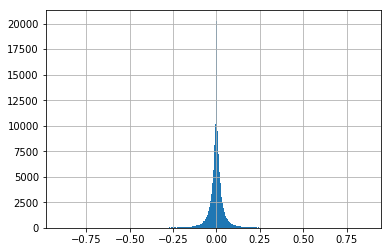

In [104]:
pyplot.show()

In [105]:
X_test_scaled["open"].hist(bins=1000)

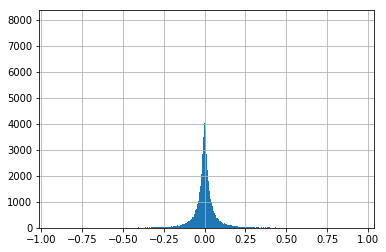

In [106]:
pyplot.show()

In [53]:
y[200:]

,sig
date_time,
2012-01-04 14:35:00+08:00,-1
2012-01-04 14:36:00+08:00,-1
2012-01-04 14:37:00+08:00,-1
2012-01-04 14:38:00+08:00,-1
2012-01-04 14:39:00+08:00,-1
2012-01-04 14:40:00+08:00,-1
2012-01-04 14:41:00+08:00,-1
2012-01-04 14:42:00+08:00,-1
2012-01-04 14:43:00+08:00,-1
